# Planning

## Big Picture
* **Frame the problem:** Supervised Learning, Univariate Classification Task, Batch Learning (No continuous flow of data, No need to adjust to changing data rapidly)
* **Performance Measure**
* **Check Assumptions**

## Get Data
* **Split Test Data** Use stratified sampling
* **Sample Exploration Set**

## Data Exploration
* Number of features
* Missing values
* Categorial or Numerical
* Correlations
* How do cancelations relate to airport location
* Look at scetterplot to detect outliers (features with outliers should be standardized, non-normal features should be normalized, use log-transformation)
* Feature Engineering

## Data Pre-Processing
* Seperate predictors and labels
* Handle Missing values
* Handle Catigorical Data (ordinal encoding or one-hot encoding)

## Select and Train Model

# Project

In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

## Import Data

In [148]:
#Specify the path to the data
path_to_data = '/Users/samuelhope/mystuff/StAndrewsYear4/Semester2/ID5059/Combined_Flights_small.csv'

#Import the data as pandas dataframe
flights_raw = pd.read_csv(path_to_data,usecols=['Airline', 'Origin', 'Dest', 'Year', 'Month','DayOfWeek','CRSDepTime','Distance','Disruption'])

# Clear the maximum number of columns to be displayed, so that all will be visible.
pd.set_option('display.max_columns', None)

display(flights_raw)

,Airline,Origin,Dest,CRSDepTime,Distance,Year,Month,DayOfWeek,Disruption
0,SkyWest Airlines Inc.,SLC,LAX,1953,590,2018,9,5,0
1,Air Wisconsin Airlines Corp,ORD,ILM,1355,760,2018,6,3,1
2,Southwest Airlines Co.,MCO,SJU,1705,1189,2018,3,3,0
3,JetBlue Airways,JFK,LAX,1046,2475,2018,2,7,0
4,Endeavor Air Inc.,ROC,JFK,1850,264,2018,10,5,0
...,...,...,...,...,...,...,...,...,...
29186,Capital Cargo International,PHL,SYR,1358,228,2022,6,2,0
29187,Southwest Airlines Co.,SMF,LGB,1715,387,2022,7,3,0
29188,SkyWest Airlines Inc.,LRD,DFW,1821,396,2022,7,3,0
29189,American Airlines Inc.,PVD,CLT,1946,683,2022,7,7,1


## Data Exploration

In [3]:
data_summary = pd.concat([flights_raw.count().to_frame('total'),
                          flights_raw.nunique().to_frame(name='nunique'),
                          flights_raw.isna().sum().to_frame(name='isna'),
                          flights_raw.dtypes.to_frame(name='Dtype')],axis=1)

data_summary

,total,nunique,isna,Dtype
Airline,29191,28,0,object
Origin,29191,369,0,object
Dest,29191,358,0,object
CRSDepTime,29191,1172,0,int64
Distance,29191,1472,0,int64
Year,29191,5,0,int64
Month,29191,12,0,int64
DayOfWeek,29191,7,0,int64
Disruption,29191,2,0,int64


We will first investigate how many flights are disrupted for different airlines.

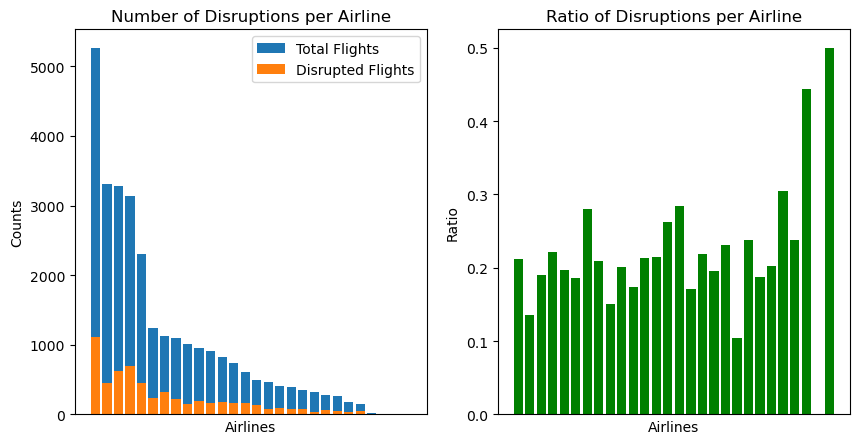

In [4]:
airline_data = pd.merge(flights_raw['Airline'].value_counts(),flights_raw.groupby('Airline')['Disruption'].sum(),left_index=True, right_index=True)
airline_data.columns = ["Flights","Disruptions"]
airline_data['Ratio'] = airline_data['Disruptions']/airline_data['Flights']

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(airline_data.index, airline_data['Flights'],label='Total Flights')
ax1.bar(airline_data.index, airline_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions per Airline')
ax1.set_xlabel('Airlines')
ax1.set_ylabel('Counts')
ax1.legend()


ax2.bar(airline_data.index, airline_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions per Airline')
ax2.set_xlabel('Airlines')
ax2.set_ylabel('Ratio')

ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

Clearly there are some airlines that have a higher ratio of disrupted flights than others.
We can see that the airlines that have fewer flights recorded in the dataset have more variation in their ratio. Still there are some airlines that have a higher ratio of disrupted flights than others with similar number of flights. There is a reasonable number of unique airlines in the dataset so we can simply use one-hot encoding to encode the airlines.

We proceed with a similar analysis for the origin airports. We can see in the above output that there are $369$ different origin airports. 

Next we will see how disruptions are distributed across the years.

Text(0, 0.5, 'Ratio')

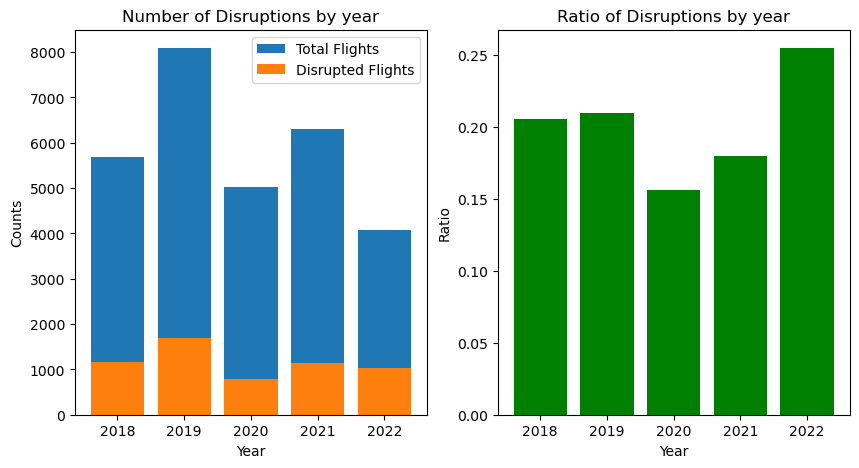

In [30]:
year_data = pd.merge(flights_raw['Year'].value_counts(),flights_raw.groupby('Year')['Disruption'].sum(),left_index=True, right_index=True)
year_data.columns = ["Flights","Disruptions"]
year_data['Ratio'] = year_data['Disruptions']/year_data['Flights']


fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(year_data.index, year_data['Flights'],label='Total Flights')
ax1.bar(year_data.index, year_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions by year')
ax1.set_xlabel('Year')
ax1.set_ylabel('Counts')
ax1.legend()


ax2.bar(year_data.index, year_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions by year')
ax2.set_xlabel('Year')
ax2.set_ylabel('Ratio')

We may want to incooperate the effects of the Covid 19 pandemic. This has lead to a strong reduction in flights in 2020 and 2021. After the pandemic a lot of airports were understaffed which could be the reason for an increased number of disruptions.

It is reasonable to assume that the number of fligths and disuptions follow a seasonal pattern throughout the year so we will proceed by looking at monthly data.

Text(0, 0.5, 'Ratio')

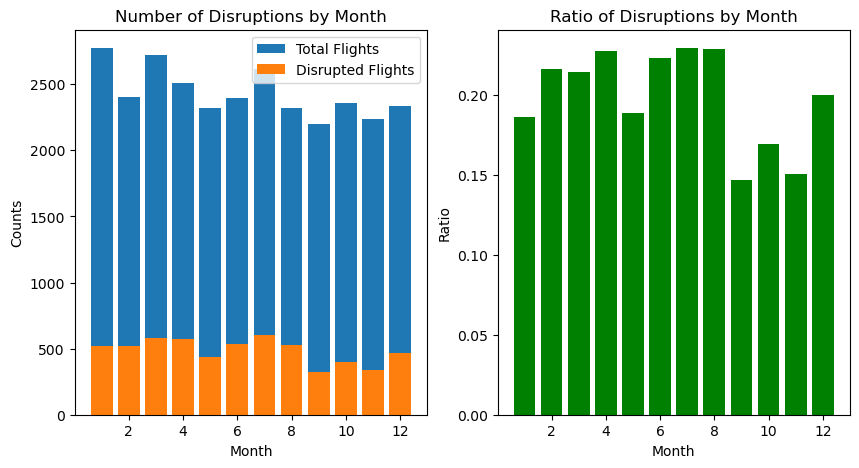

In [8]:
month_data = pd.merge(flights_raw['Month'].value_counts(),flights_raw.groupby('Month')['Disruption'].sum(),left_index=True, right_index=True)
month_data.columns = ["Flights","Disruptions"]
month_data['Ratio'] = month_data['Disruptions']/month_data['Flights']


fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(month_data.index, month_data['Flights'],label='Total Flights')
ax1.bar(month_data.index, month_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions by Month')
ax1.set_xlabel('Month')
ax1.set_ylabel('Counts')
ax1.legend()


ax2.bar(month_data.index, month_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions by Month')
ax2.set_xlabel('Month')
ax2.set_ylabel('Ratio')

Clearly there is a higher ratio of disrupted flights in months April, Juli and August, compared to September, October and November. 

To see how the time of day of departure affects flight disruptions, we group time into 4 hour bins.

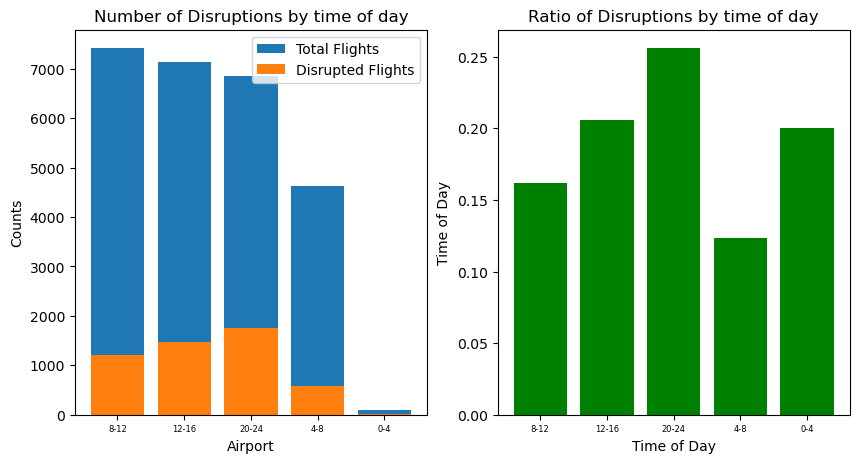

In [10]:
flights_raw['time'] = flights_raw['CRSDepTime'] // 100
bins = [0,4,8,12,16,20]
labels = ['0-4', '4-8', '8-12', '12-16', '20-24']
flights_raw['TimeOfDay'] = pd.cut(flights_raw['time'], bins=bins, labels=labels, right=False)

nflights_by_time = flights_raw['TimeOfDay'].value_counts()
ndisruptions_by_time = flights_raw.groupby('TimeOfDay')['Disruption'].sum()
time_data = pd.merge(nflights_by_time,ndisruptions_by_time,left_index=True, right_index=True)
time_data.columns = ["Flights","Disruptions"]
time_data['Ratio'] = time_data['Disruptions']/time_data['Flights']

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(time_data.index, time_data['Flights'],label='Total Flights')
ax1.bar(time_data.index, time_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions by time of day')
ax1.set_xlabel('Time of Day')
ax1.set_ylabel('Counts')
ax1.legend()


ax2.bar(time_data.index, time_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions by time of day')
ax2.set_xlabel('Time of Day')
ax2.set_ylabel('Ratio')

ax1.tick_params(axis='x', which='both', labelsize = 6)
ax2.tick_params(axis='x', which='both', labelsize = 6)

We can see that we have similar numbers of flights between 8AM and midinight, and that there are noticably more disruptions between 8PM and midnight. This makes sense as disruptions throughout the day may have affected later flights throughout the day. We will therefore feature engineer a new clolumn 'TimeOfDay' for the corresponding time of departure.

We will now check whether the distance of the flight has an impact on how likely the flight is to be disrupted.

,Distance,Disruption
Distance,1.000000,0.010277
Disruption,0.010277,1.000000


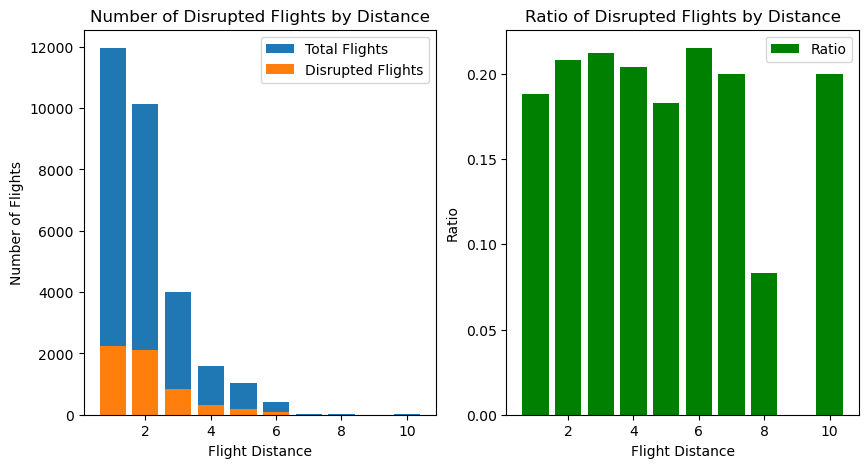

In [40]:
#Split the distances into 10 groups
flights_raw['Distance_Group'] = pd.cut(flights_raw['Distance'], bins=10,labels=[1,2,3,4,5,6,7,8,9,10])
distance_data = pd.merge(flights_raw['Distance_Group'].value_counts(),flights_raw.groupby('Distance_Group')['Disruption'].sum(),left_index=True, right_index=True)
distance_data.columns = ["Flights","Disruptions"]


fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(distance_data.index,distance_data['Flights'], label='Total Flights')
ax1.bar(distance_data.index,distance_data['Disruptions'],label='Disrupted Flights')
ax1.set_xlabel('Flight Distance')
ax1.set_ylabel('Number of Flights')
ax1.set_title('Number of Disrupted Flights by Distance')
ax1.legend()

ax2.bar(distance_data.index,distance_data['Disruptions']/distance_data['Flights'], label='Ratio',color='green')
ax2.set_xlabel('Flight Distance')
ax2.set_ylabel('Ratio')
ax2.set_title('Ratio of Disrupted Flights by Distance')
ax2.legend()

flights_raw[['Distance','Disruption']].corr()

We can see that the total number of flights decreases with increased distance but the ratio of disrupted flights to number of flights roughly stays the same. Additionally, the variables `'Distance'` and `'Disruption'`have a low correlation of $0.010277$. We will thus not include this feature in our model.

Next we will investigate how the origin airport affects the chance of a flight being disrupted. There are too many different airports in the dataset so we need to somehow group the data. We first investigate if the busyness of the airport has an impact on the ratio of disrupted flights

29191

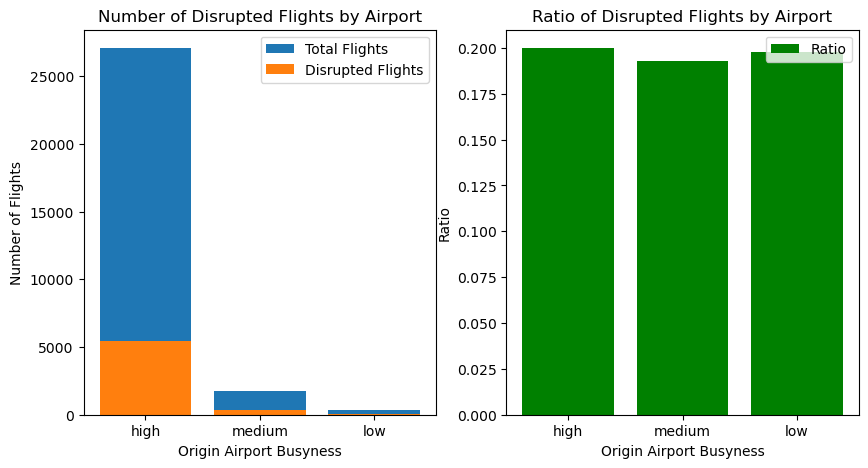

In [131]:
threshholds = list(flights_raw['Origin'].value_counts().quantile([0.33,0.66]))
airline_freqs = flights_raw['Origin'].value_counts()
flights_raw['Busy'] = np.where((airline_freqs[flights_raw['Origin']]<threshholds[0]),'low',
                               np.where((airline_freqs[flights_raw['Origin']]<threshholds[1]),'medium','high'))


busy_data = pd.merge(flights_raw['Busy'].value_counts(),flights_raw.groupby('Busy')['Disruption'].sum(),left_index=True, right_index=True)
busy_data.columns = ["Flights","Disruptions"]

fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(busy_data.index,busy_data['Flights'], label='Total Flights')
ax1.bar(busy_data.index,busy_data['Disruptions'],label='Disrupted Flights')
ax1.set_xlabel('Origin Airport Busyness')
ax1.set_ylabel('Number of Flights')
ax1.set_title('Number of Disrupted Flights by Airport')
ax1.legend()

ax2.bar(busy_data.index,busy_data['Disruptions']/busy_data['Flights'], label='Ratio',color='green')
ax2.set_xlabel('Origin Airport Busyness')
ax2.set_ylabel('Ratio')
ax2.set_title('Ratio of Disrupted Flights by Airport')
ax2.legend()

flights_raw['Busy'].value_counts().sum()

The graphs don't suggest that the busyness impacts the relative number of disrupted flights. Let's see how much the disruption rate varies across different origin airports.

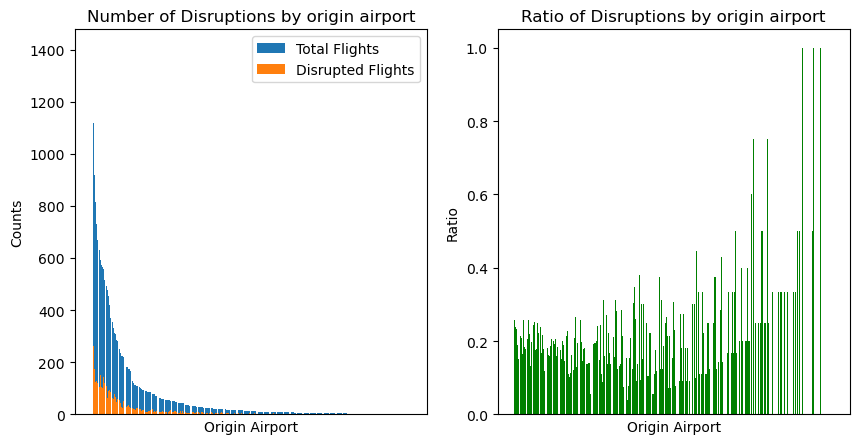

In [133]:
origin_data = pd.merge(flights_raw['Origin'].value_counts(),
                       flights_raw.groupby('Origin')['Disruption'].sum(),
                       left_index=True, right_index=True)

origin_data.columns = ["Flights", "Disruptions"]
origin_data['Ratio'] = origin_data['Disruptions']/origin_data['Flights']


fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize=(10,5))
ax1.bar(origin_data.index, origin_data['Flights'],label='Total Flights')
ax1.bar(origin_data.index, origin_data['Disruptions'], label='Disrupted Flights')
ax1.set_title('Number of Disruptions by origin airport')
ax1.set_xlabel('Origin Airport')
ax1.set_ylabel('Counts')
ax1.legend()
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

ax2.bar(origin_data.index, origin_data['Ratio'],color="green")
ax2.set_title('Ratio of Disruptions by origin airport')
ax2.set_xlabel('Origin Airport')
ax2.set_ylabel('Ratio')
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

### Summary
We feature engineer the following features:
* `'TimeOfDay'` (Time split into 5 bins)

We one-hotencode the following features as they are non-ordinal:
* `'Airline'`

Use Label encoding for the following features
* `'Year'`
* `'Month'`
* `'TimeOfDay'`

Use target encoding for the following features
* `'Origin'`
* `'Dest'`

## Feature Engineering and Preprocessing

In [154]:
#Make 'TimeOfDay' column
hour = flights_raw['CRSDepTime'] // 100
bins = [0, 4, 8, 12, 16, 20,float('inf')]
labels = [1, 2, 3, 4, 5, 6]
flights_raw['TimeOfDay'] = pd.cut(hour, bins=bins, labels=labels, right=False)

features = ['Airline', 'Origin', 'Dest', 'Year', 'Month','DayOfWeek','TimeOfDay','Disruption']

# Define the features to be one-hot encoded, label encoded and target encoded
ordinal_encode_features = ['DayOfWeek', 'Month', 'Year', 'TimeOfDay']
target_encode_features = ['Origin', 'Dest']
one_hot_encode_features = ['Airline']


#Split of labels
X = flights_raw[features].drop('Disruption', axis = 1)
y = flights_raw['Disruption']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)


#Define transformer to make 'TimeOfDay' feature

#class TimeOfDayTransformer(BaseEstimator, TransformerMixin):
    #def fit(self, X, y=None):
        #return self
    
    #def transform(self, X):
        #X['CRSDepTime'] = X['CRSDepTime'] // 100
        #bins = [0, 4, 8, 12, 16, 20]
        #labels = [1, 2, 3, 4, 5]
        #X['TimeOfDay'] = pd.cut(X['CRSDepTime'], bins=bins, labels=labels, right=False)
        #X.drop(columns=['CRSDepTime'], inplace=True)
        #return X
    


preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot', OneHotEncoder(), one_hot_encode_features),
        ('target_encode', TargetEncoder(), target_encode_features),
        ('ordinal_encode', OrdinalEncoder(), ordinal_encode_features),
    ],
    remainder='passthrough'
)

In [170]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Evaluate on the test set
predictions = pipeline.predict(X_test)
accuracy_score(y_test, predictions)

0.7997944853570816

In [172]:
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(loss="hinge"))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Evaluate on the test set
predictions = pipeline.predict(X_test)
accuracy_score(y_test, predictions)

0.8054461380373351